In [1]:
import tensorflow
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, BatchNormalization, ReLU, Conv2D, Dense, MaxPool2D, AvgPool2D, GlobalAvgPool2D, Concatenate

##############
import os

from os import listdir
from os.path import isfile, join
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import InceptionV3

In [2]:
currentPath = os.getcwd()
print(currentPath)

/home/ec2-user/SageMaker


In [3]:
gpus = tensorflow.config.experimental.list_physical_devices('GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


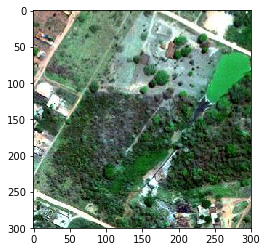

In [4]:
trainDB = currentPath + os.sep + "dataset" +  os.sep + "train20"
valDB = currentPath + os.sep + "dataset" +  os.sep + "val20"
data_set_path = currentPath + os.sep + "fMoW" + os.sep
InceptionWeightsPretrained = currentPath + os.sep + "inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
model_name = "InceptionV3"
classList = os.listdir(trainDB)
classList.sort()

img = mpimg.imread(trainDB + os.sep + "airport" + os.sep + "airport_7_8_msrgb.jpg")
imgplot = plt.imshow(img)

In [5]:
lr = 0.00012
batch_size = 20
num_epochs = 700
pre_train_epochs = 20

num_steps_per_epoch = 4
img_rows, img_cols, img_channel = 299, 299, 3
num_categories = len(classList)

In [6]:
train_data_gen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=270,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval = 0.)
    
train_generator = train_data_gen.flow_from_directory(
    directory=trainDB,
    target_size=(img_cols, img_rows),
    batch_size=batch_size,
    class_mode='categorical'
)

val_data_gen = ImageDataGenerator(
    rescale=1. / 225,
)
val_generator = val_data_gen.flow_from_directory(
    directory=valDB,
    target_size=(img_cols, img_rows),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 927 images belonging to 62 classes.
Found 305 images belonging to 62 classes.


In [7]:
print(train_generator.class_indices)
imgs, labels = next(train_generator)

{'airport': 0, 'airport_hangar': 1, 'airport_terminal': 2, 'amusement_park': 3, 'aquaculture': 4, 'archaeological_site': 5, 'barn': 6, 'border_checkpoint': 7, 'burial_site': 8, 'car_dealership': 9, 'construction_site': 10, 'crop_field': 11, 'dam': 12, 'debris_or_rubble': 13, 'educational_institution': 14, 'electric_substation': 15, 'factory_or_powerplant': 16, 'fire_station': 17, 'flooded_road': 18, 'fountain': 19, 'gas_station': 20, 'golf_course': 21, 'ground_transportation_station': 22, 'helipad': 23, 'hospital': 24, 'impoverished_settlement': 25, 'interchange': 26, 'lake_or_pond': 27, 'lighthouse': 28, 'military_facility': 29, 'multi-unit_residential': 30, 'nuclear_powerplant': 31, 'office_building': 32, 'oil_or_gas_facility': 33, 'park': 34, 'parking_lot_or_garage': 35, 'place_of_worship': 36, 'police_station': 37, 'port': 38, 'prison': 39, 'race_track': 40, 'railway_bridge': 41, 'recreational_facility': 42, 'road_bridge': 43, 'runway': 44, 'shipyard': 45, 'shopping_mall': 46, 'sin

In [8]:
input = Input(shape=(img_rows, img_cols, img_channel))

In [9]:
def InceptionV3Custom(shape,pretrainedweights, input_tensor, classes):
    InV3NoTop = InceptionV3(
        include_top=False, weights=pretrainedweights, input_tensor=input_tensor, input_shape=shape)
    
    InV3Out = InV3NoTop.layers[-1].output
    x = GlobalAvgPool2D()(InV3Out)
    output = Dense(classes, activation="softmax")(x)
    model = Model(input_tensor, output)
        
    return model

In [10]:
model = InceptionV3Custom((img_rows, img_cols, img_channel),InceptionWeightsPretrained, input, num_categories)

model.summary()
#plot_model(model, show_shapes=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_____________

In [11]:
#optimizeFunc = SGD(learning_rate=lr, momentum=0.9, nesterov=True, decay=1e-6)
optimizeFunc = Adam(learning_rate=lr)
#model.compile(optimizer=optimizeFunc, loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=optimizeFunc, loss='categorical_crossentropy', metrics=[tensorflow.keras.metrics.CategoricalAccuracy()])

In [12]:
history = model.fit_generator(
    generator=train_generator,
    validation_data=val_generator,
    steps_per_epoch=num_steps_per_epoch,
    # initial_epoch=pre_train_epochs,
    epochs=num_epochs,
    validation_steps=num_steps_per_epoch,
    verbose=1)

Epoch 1/700
4/4 [==============================] - 52s 13s/step - loss: 4.2573 - categorical_accuracy: 0.0125 - val_loss: 4.2673 - val_categorical_accuracy: 0.0500
Epoch 2/700
4/4 [==============================] - 4s 979ms/step - loss: 4.1159 - categorical_accuracy: 0.0250 - val_loss: 4.2216 - val_categorical_accuracy: 0.0500
Epoch 3/700
4/4 [==============================] - 4s 992ms/step - loss: 4.1293 - categorical_accuracy: 0.0250 - val_loss: 4.2163 - val_categorical_accuracy: 0.0250
Epoch 4/700
4/4 [==============================] - 4s 979ms/step - loss: 4.3140 - categorical_accuracy: 0.0500 - val_loss: 4.1911 - val_categorical_accuracy: 0.0250
Epoch 5/700
4/4 [==============================] - 4s 991ms/step - loss: 4.2151 - categorical_accuracy: 0.0250 - val_loss: 4.1588 - val_categorical_accuracy: 0.0375
Epoch 6/700
4/4 [==============================] - 4s 987ms/step - loss: 4.0707 - categorical_accuracy: 0.0500 - val_loss: 4.1395 - val_categorical_accuracy: 0.0375
Epoch 7/700

4/4 [==============================] - 4s 995ms/step - loss: 3.5260 - categorical_accuracy: 0.1375 - val_loss: 3.4365 - val_categorical_accuracy: 0.1750
Epoch 24/700
4/4 [==============================] - 4s 1s/step - loss: 3.0058 - categorical_accuracy: 0.3000 - val_loss: 3.4034 - val_categorical_accuracy: 0.2000
Epoch 25/700
4/4 [==============================] - 4s 1s/step - loss: 2.7975 - categorical_accuracy: 0.3375 - val_loss: 3.3699 - val_categorical_accuracy: 0.2375
Epoch 26/700
4/4 [==============================] - 4s 1s/step - loss: 2.8245 - categorical_accuracy: 0.3125 - val_loss: 3.3662 - val_categorical_accuracy: 0.1875
Epoch 27/700
4/4 [==============================] - 4s 995ms/step - loss: 2.8314 - categorical_accuracy: 0.3000 - val_loss: 3.3752 - val_categorical_accuracy: 0.1750
Epoch 28/700
4/4 [==============================] - 4s 1s/step - loss: 2.9495 - categorical_accuracy: 0.2500 - val_loss: 3.3704 - val_categorical_accuracy: 0.1875
Epoch 29/700
4/4 [===========

4/4 [==============================] - 4s 994ms/step - loss: 2.3562 - categorical_accuracy: 0.4125 - val_loss: 3.3677 - val_categorical_accuracy: 0.2125
Epoch 46/700
4/4 [==============================] - 4s 1s/step - loss: 2.3107 - categorical_accuracy: 0.4125 - val_loss: 3.3308 - val_categorical_accuracy: 0.2500
Epoch 47/700
4/4 [==============================] - 4s 1s/step - loss: 2.2901 - categorical_accuracy: 0.4250 - val_loss: 3.3258 - val_categorical_accuracy: 0.2250
Epoch 48/700
4/4 [==============================] - 4s 1s/step - loss: 2.0503 - categorical_accuracy: 0.4875 - val_loss: 3.4057 - val_categorical_accuracy: 0.2250
Epoch 49/700
4/4 [==============================] - 4s 914ms/step - loss: 1.7308 - categorical_accuracy: 0.5821 - val_loss: 3.5192 - val_categorical_accuracy: 0.2000
Epoch 50/700
4/4 [==============================] - 4s 1s/step - loss: 2.0369 - categorical_accuracy: 0.4625 - val_loss: 3.6099 - val_categorical_accuracy: 0.1750
Epoch 51/700
4/4 [===========

Epoch 68/700
4/4 [==============================] - 4s 1s/step - loss: 1.6792 - categorical_accuracy: 0.5625 - val_loss: 3.4338 - val_categorical_accuracy: 0.2250
Epoch 69/700
4/4 [==============================] - 4s 1s/step - loss: 1.6891 - categorical_accuracy: 0.6125 - val_loss: 3.4380 - val_categorical_accuracy: 0.2125
Epoch 70/700
4/4 [==============================] - 4s 997ms/step - loss: 1.5112 - categorical_accuracy: 0.6375 - val_loss: 3.4519 - val_categorical_accuracy: 0.2125
Epoch 71/700
4/4 [==============================] - 4s 1s/step - loss: 1.4628 - categorical_accuracy: 0.7125 - val_loss: 3.4528 - val_categorical_accuracy: 0.2250
Epoch 72/700
4/4 [==============================] - 4s 1s/step - loss: 1.1852 - categorical_accuracy: 0.7125 - val_loss: 3.4290 - val_categorical_accuracy: 0.2125
Epoch 73/700
4/4 [==============================] - 4s 1s/step - loss: 1.4287 - categorical_accuracy: 0.6625 - val_loss: 3.4112 - val_categorical_accuracy: 0.2250
Epoch 74/700
4/4 [=

4/4 [==============================] - 4s 1s/step - loss: 0.9479 - categorical_accuracy: 0.8000 - val_loss: 2.8927 - val_categorical_accuracy: 0.2875
Epoch 91/700
4/4 [==============================] - 4s 1s/step - loss: 1.2480 - categorical_accuracy: 0.6750 - val_loss: 2.9324 - val_categorical_accuracy: 0.2625
Epoch 92/700
4/4 [==============================] - 4s 1s/step - loss: 0.9106 - categorical_accuracy: 0.7625 - val_loss: 2.9255 - val_categorical_accuracy: 0.2625
Epoch 93/700
4/4 [==============================] - 4s 996ms/step - loss: 1.2117 - categorical_accuracy: 0.7125 - val_loss: 2.8873 - val_categorical_accuracy: 0.3000
Epoch 94/700
4/4 [==============================] - 4s 912ms/step - loss: 1.3891 - categorical_accuracy: 0.6119 - val_loss: 2.8684 - val_categorical_accuracy: 0.3000
Epoch 95/700
4/4 [==============================] - 4s 1s/step - loss: 0.8963 - categorical_accuracy: 0.8375 - val_loss: 2.8715 - val_categorical_accuracy: 0.2750
Epoch 96/700
4/4 [===========

Epoch 113/700
4/4 [==============================] - 4s 1s/step - loss: 0.7488 - categorical_accuracy: 0.8125 - val_loss: 2.9472 - val_categorical_accuracy: 0.2625
Epoch 114/700
4/4 [==============================] - 4s 997ms/step - loss: 0.5083 - categorical_accuracy: 0.9000 - val_loss: 2.9072 - val_categorical_accuracy: 0.2750
Epoch 115/700
4/4 [==============================] - 4s 1s/step - loss: 0.6325 - categorical_accuracy: 0.9000 - val_loss: 2.8979 - val_categorical_accuracy: 0.2750
Epoch 116/700
4/4 [==============================] - 4s 1s/step - loss: 0.8239 - categorical_accuracy: 0.7750 - val_loss: 2.9172 - val_categorical_accuracy: 0.2625
Epoch 117/700
4/4 [==============================] - 4s 1s/step - loss: 0.7782 - categorical_accuracy: 0.8000 - val_loss: 2.9630 - val_categorical_accuracy: 0.2625
Epoch 118/700
4/4 [==============================] - 4s 1s/step - loss: 0.5739 - categorical_accuracy: 0.9250 - val_loss: 2.9563 - val_categorical_accuracy: 0.2750
Epoch 119/700

4/4 [==============================] - 4s 911ms/step - loss: 0.6736 - categorical_accuracy: 0.8657 - val_loss: 2.9655 - val_categorical_accuracy: 0.3500
Epoch 136/700
4/4 [==============================] - 4s 1s/step - loss: 0.3332 - categorical_accuracy: 0.9625 - val_loss: 3.0040 - val_categorical_accuracy: 0.3125
Epoch 137/700
4/4 [==============================] - 4s 998ms/step - loss: 0.4158 - categorical_accuracy: 0.9375 - val_loss: 3.0735 - val_categorical_accuracy: 0.3125
Epoch 138/700
4/4 [==============================] - 4s 997ms/step - loss: 0.4282 - categorical_accuracy: 0.9125 - val_loss: 3.0873 - val_categorical_accuracy: 0.2875
Epoch 139/700
4/4 [==============================] - 4s 1s/step - loss: 0.3645 - categorical_accuracy: 0.9250 - val_loss: 3.0768 - val_categorical_accuracy: 0.2875
Epoch 140/700
4/4 [==============================] - 4s 1s/step - loss: 0.4508 - categorical_accuracy: 0.9250 - val_loss: 3.0824 - val_categorical_accuracy: 0.2875
Epoch 141/700
4/4 [==

4/4 [==============================] - 4s 1s/step - loss: 0.2354 - categorical_accuracy: 0.9500 - val_loss: 3.3999 - val_categorical_accuracy: 0.2750
Epoch 158/700
4/4 [==============================] - 4s 999ms/step - loss: 0.2697 - categorical_accuracy: 0.9875 - val_loss: 3.3862 - val_categorical_accuracy: 0.2500
Epoch 159/700
4/4 [==============================] - 4s 994ms/step - loss: 0.1822 - categorical_accuracy: 0.9750 - val_loss: 3.3527 - val_categorical_accuracy: 0.2500
Epoch 160/700
4/4 [==============================] - 4s 1s/step - loss: 0.2429 - categorical_accuracy: 0.9625 - val_loss: 3.3258 - val_categorical_accuracy: 0.2375
Epoch 161/700
4/4 [==============================] - 4s 1s/step - loss: 0.2293 - categorical_accuracy: 0.9750 - val_loss: 3.3057 - val_categorical_accuracy: 0.2625
Epoch 162/700
4/4 [==============================] - 4s 911ms/step - loss: 0.2197 - categorical_accuracy: 0.9701 - val_loss: 3.2890 - val_categorical_accuracy: 0.2875
Epoch 163/700
4/4 [==

Epoch 180/700
4/4 [==============================] - 4s 1s/step - loss: 0.1232 - categorical_accuracy: 0.9875 - val_loss: 3.2853 - val_categorical_accuracy: 0.2625
Epoch 181/700
4/4 [==============================] - 4s 1s/step - loss: 0.1941 - categorical_accuracy: 0.9750 - val_loss: 3.2593 - val_categorical_accuracy: 0.2500
Epoch 182/700
4/4 [==============================] - 4s 1s/step - loss: 0.1513 - categorical_accuracy: 1.0000 - val_loss: 3.2251 - val_categorical_accuracy: 0.2625
Epoch 183/700
4/4 [==============================] - 4s 914ms/step - loss: 0.2382 - categorical_accuracy: 0.9851 - val_loss: 3.1769 - val_categorical_accuracy: 0.2750
Epoch 184/700
4/4 [==============================] - 4s 1s/step - loss: 0.1881 - categorical_accuracy: 0.9625 - val_loss: 3.1277 - val_categorical_accuracy: 0.3125
Epoch 185/700
4/4 [==============================] - 4s 1s/step - loss: 0.1249 - categorical_accuracy: 1.0000 - val_loss: 3.1348 - val_categorical_accuracy: 0.3375
Epoch 186/700

4/4 [==============================] - 4s 1s/step - loss: 0.1351 - categorical_accuracy: 0.9625 - val_loss: 3.3198 - val_categorical_accuracy: 0.3000
Epoch 203/700
4/4 [==============================] - 4s 1s/step - loss: 0.1493 - categorical_accuracy: 0.9875 - val_loss: 3.3124 - val_categorical_accuracy: 0.3000
Epoch 204/700
4/4 [==============================] - 4s 1s/step - loss: 0.1414 - categorical_accuracy: 0.9750 - val_loss: 3.3088 - val_categorical_accuracy: 0.2625
Epoch 205/700
4/4 [==============================] - 4s 1s/step - loss: 0.2054 - categorical_accuracy: 0.9500 - val_loss: 3.3296 - val_categorical_accuracy: 0.2500
Epoch 206/700
4/4 [==============================] - 4s 1s/step - loss: 0.2112 - categorical_accuracy: 0.9625 - val_loss: 3.3355 - val_categorical_accuracy: 0.2750
Epoch 207/700
4/4 [==============================] - 4s 1s/step - loss: 0.1306 - categorical_accuracy: 0.9875 - val_loss: 3.3323 - val_categorical_accuracy: 0.2500
Epoch 208/700
4/4 [===========

Epoch 225/700
4/4 [==============================] - 4s 1s/step - loss: 0.0836 - categorical_accuracy: 1.0000 - val_loss: 3.4646 - val_categorical_accuracy: 0.2625
Epoch 226/700
4/4 [==============================] - 4s 999ms/step - loss: 0.0746 - categorical_accuracy: 1.0000 - val_loss: 3.4844 - val_categorical_accuracy: 0.2750
Epoch 227/700
4/4 [==============================] - 4s 998ms/step - loss: 0.1654 - categorical_accuracy: 0.9875 - val_loss: 3.4721 - val_categorical_accuracy: 0.2750
Epoch 228/700
4/4 [==============================] - 4s 1s/step - loss: 0.0933 - categorical_accuracy: 0.9875 - val_loss: 3.4679 - val_categorical_accuracy: 0.2875
Epoch 229/700
4/4 [==============================] - 4s 1s/step - loss: 0.0969 - categorical_accuracy: 1.0000 - val_loss: 3.4410 - val_categorical_accuracy: 0.3125
Epoch 230/700
4/4 [==============================] - 4s 1s/step - loss: 0.0696 - categorical_accuracy: 1.0000 - val_loss: 3.4201 - val_categorical_accuracy: 0.3250
Epoch 231/

4/4 [==============================] - 4s 1s/step - loss: 0.1927 - categorical_accuracy: 0.9750 - val_loss: 3.3980 - val_categorical_accuracy: 0.3000
Epoch 248/700
4/4 [==============================] - 4s 1s/step - loss: 0.0657 - categorical_accuracy: 0.9875 - val_loss: 3.4541 - val_categorical_accuracy: 0.2875
Epoch 249/700
4/4 [==============================] - 4s 1s/step - loss: 0.1100 - categorical_accuracy: 0.9875 - val_loss: 3.4731 - val_categorical_accuracy: 0.3000
Epoch 250/700
4/4 [==============================] - 4s 1s/step - loss: 0.1443 - categorical_accuracy: 0.9875 - val_loss: 3.4453 - val_categorical_accuracy: 0.2750
Epoch 251/700
4/4 [==============================] - 4s 1s/step - loss: 0.0464 - categorical_accuracy: 1.0000 - val_loss: 3.3950 - val_categorical_accuracy: 0.2750
Epoch 252/700
4/4 [==============================] - 4s 1s/step - loss: 0.0638 - categorical_accuracy: 1.0000 - val_loss: 3.3616 - val_categorical_accuracy: 0.2750
Epoch 253/700
4/4 [===========

4/4 [==============================] - 4s 1s/step - loss: 0.0995 - categorical_accuracy: 0.9875 - val_loss: 3.0406 - val_categorical_accuracy: 0.2500
Epoch 270/700
4/4 [==============================] - 4s 1s/step - loss: 0.0635 - categorical_accuracy: 1.0000 - val_loss: 3.0683 - val_categorical_accuracy: 0.2875
Epoch 271/700
4/4 [==============================] - 4s 1s/step - loss: 0.0708 - categorical_accuracy: 0.9875 - val_loss: 3.1045 - val_categorical_accuracy: 0.3250
Epoch 272/700
4/4 [==============================] - 4s 1s/step - loss: 0.0955 - categorical_accuracy: 0.9875 - val_loss: 3.1566 - val_categorical_accuracy: 0.2750
Epoch 273/700
4/4 [==============================] - 4s 1s/step - loss: 0.0465 - categorical_accuracy: 1.0000 - val_loss: 3.2260 - val_categorical_accuracy: 0.2750
Epoch 274/700
4/4 [==============================] - 4s 1s/step - loss: 0.0589 - categorical_accuracy: 0.9875 - val_loss: 3.2918 - val_categorical_accuracy: 0.2875
Epoch 275/700
4/4 [===========

Epoch 292/700
4/4 [==============================] - 4s 1s/step - loss: 0.1319 - categorical_accuracy: 0.9625 - val_loss: 3.7313 - val_categorical_accuracy: 0.2500
Epoch 293/700
4/4 [==============================] - 4s 995ms/step - loss: 0.0516 - categorical_accuracy: 1.0000 - val_loss: 3.6697 - val_categorical_accuracy: 0.2500
Epoch 294/700
4/4 [==============================] - 4s 1s/step - loss: 0.0880 - categorical_accuracy: 0.9875 - val_loss: 3.5695 - val_categorical_accuracy: 0.2750
Epoch 295/700
4/4 [==============================] - 4s 1s/step - loss: 0.0464 - categorical_accuracy: 1.0000 - val_loss: 3.5153 - val_categorical_accuracy: 0.2750
Epoch 296/700
4/4 [==============================] - 4s 1s/step - loss: 0.0739 - categorical_accuracy: 1.0000 - val_loss: 3.4935 - val_categorical_accuracy: 0.2750
Epoch 297/700
4/4 [==============================] - 4s 1s/step - loss: 0.1135 - categorical_accuracy: 0.9875 - val_loss: 3.4751 - val_categorical_accuracy: 0.2875
Epoch 298/700

4/4 [==============================] - 4s 1s/step - loss: 0.0891 - categorical_accuracy: 0.9750 - val_loss: 3.9529 - val_categorical_accuracy: 0.2250
Epoch 315/700
4/4 [==============================] - 4s 1s/step - loss: 0.0603 - categorical_accuracy: 0.9875 - val_loss: 3.8929 - val_categorical_accuracy: 0.2125
Epoch 316/700
4/4 [==============================] - 4s 996ms/step - loss: 0.1377 - categorical_accuracy: 0.9500 - val_loss: 3.9288 - val_categorical_accuracy: 0.1875
Epoch 317/700
4/4 [==============================] - 4s 1s/step - loss: 0.1404 - categorical_accuracy: 0.9625 - val_loss: 3.9416 - val_categorical_accuracy: 0.1500
Epoch 318/700
4/4 [==============================] - 4s 1s/step - loss: 0.1484 - categorical_accuracy: 0.9625 - val_loss: 3.8994 - val_categorical_accuracy: 0.1875
Epoch 319/700
4/4 [==============================] - 4s 1s/step - loss: 0.0505 - categorical_accuracy: 1.0000 - val_loss: 3.9037 - val_categorical_accuracy: 0.1750
Epoch 320/700
4/4 [========

4/4 [==============================] - 4s 912ms/step - loss: 0.2314 - categorical_accuracy: 0.9403 - val_loss: 3.7972 - val_categorical_accuracy: 0.1750
Epoch 337/700
4/4 [==============================] - 4s 1s/step - loss: 0.1421 - categorical_accuracy: 0.9750 - val_loss: 3.9651 - val_categorical_accuracy: 0.1875
Epoch 338/700
4/4 [==============================] - 4s 1s/step - loss: 0.1668 - categorical_accuracy: 0.9500 - val_loss: 4.0710 - val_categorical_accuracy: 0.1750
Epoch 339/700
4/4 [==============================] - 4s 1s/step - loss: 0.1442 - categorical_accuracy: 0.9750 - val_loss: 4.0550 - val_categorical_accuracy: 0.1625
Epoch 340/700
4/4 [==============================] - 4s 1s/step - loss: 0.1366 - categorical_accuracy: 0.9750 - val_loss: 3.9541 - val_categorical_accuracy: 0.1875
Epoch 341/700
4/4 [==============================] - 4s 1s/step - loss: 0.1099 - categorical_accuracy: 0.9750 - val_loss: 3.9360 - val_categorical_accuracy: 0.1750
Epoch 342/700
4/4 [========

Epoch 359/700
4/4 [==============================] - 4s 1s/step - loss: 0.0679 - categorical_accuracy: 0.9875 - val_loss: 3.8379 - val_categorical_accuracy: 0.2375
Epoch 360/700
4/4 [==============================] - 4s 901ms/step - loss: 0.1135 - categorical_accuracy: 0.9851 - val_loss: 3.9740 - val_categorical_accuracy: 0.2625
Epoch 361/700
4/4 [==============================] - 4s 1s/step - loss: 0.0777 - categorical_accuracy: 0.9875 - val_loss: 4.1634 - val_categorical_accuracy: 0.2250
Epoch 362/700
4/4 [==============================] - 4s 998ms/step - loss: 0.1650 - categorical_accuracy: 0.9750 - val_loss: 4.2537 - val_categorical_accuracy: 0.2500
Epoch 363/700
4/4 [==============================] - 4s 994ms/step - loss: 0.1214 - categorical_accuracy: 0.9750 - val_loss: 4.2476 - val_categorical_accuracy: 0.2750
Epoch 364/700
4/4 [==============================] - 4s 1s/step - loss: 0.1009 - categorical_accuracy: 1.0000 - val_loss: 4.1965 - val_categorical_accuracy: 0.2750
Epoch 3

4/4 [==============================] - 4s 1s/step - loss: 0.0298 - categorical_accuracy: 1.0000 - val_loss: 3.7377 - val_categorical_accuracy: 0.2125
Epoch 382/700
4/4 [==============================] - 4s 1s/step - loss: 0.0611 - categorical_accuracy: 0.9875 - val_loss: 3.7274 - val_categorical_accuracy: 0.2500
Epoch 383/700
4/4 [==============================] - 4s 999ms/step - loss: 0.0624 - categorical_accuracy: 1.0000 - val_loss: 3.7222 - val_categorical_accuracy: 0.2250
Epoch 384/700
4/4 [==============================] - 4s 994ms/step - loss: 0.0375 - categorical_accuracy: 1.0000 - val_loss: 3.7244 - val_categorical_accuracy: 0.2375
Epoch 385/700
4/4 [==============================] - 4s 999ms/step - loss: 0.0616 - categorical_accuracy: 0.9875 - val_loss: 3.7174 - val_categorical_accuracy: 0.2500
Epoch 386/700
4/4 [==============================] - 4s 897ms/step - loss: 0.0931 - categorical_accuracy: 1.0000 - val_loss: 3.7233 - val_categorical_accuracy: 0.2500
Epoch 387/700
4/4 

4/4 [==============================] - 4s 1s/step - loss: 0.0186 - categorical_accuracy: 1.0000 - val_loss: 3.5976 - val_categorical_accuracy: 0.2500
Epoch 404/700
4/4 [==============================] - 4s 1s/step - loss: 0.0244 - categorical_accuracy: 1.0000 - val_loss: 3.5996 - val_categorical_accuracy: 0.2375
Epoch 405/700
4/4 [==============================] - 4s 1s/step - loss: 0.0543 - categorical_accuracy: 0.9875 - val_loss: 3.5912 - val_categorical_accuracy: 0.2500
Epoch 406/700
4/4 [==============================] - 4s 1s/step - loss: 0.0179 - categorical_accuracy: 1.0000 - val_loss: 3.5952 - val_categorical_accuracy: 0.2625
Epoch 407/700
4/4 [==============================] - 4s 1s/step - loss: 0.0218 - categorical_accuracy: 1.0000 - val_loss: 3.6035 - val_categorical_accuracy: 0.2750
Epoch 408/700
4/4 [==============================] - 4s 999ms/step - loss: 0.0216 - categorical_accuracy: 1.0000 - val_loss: 3.6149 - val_categorical_accuracy: 0.2625
Epoch 409/700
4/4 [========

Epoch 426/700
4/4 [==============================] - 4s 904ms/step - loss: 0.0857 - categorical_accuracy: 1.0000 - val_loss: 3.5524 - val_categorical_accuracy: 0.2250
Epoch 427/700
4/4 [==============================] - 4s 1s/step - loss: 0.0708 - categorical_accuracy: 0.9875 - val_loss: 3.5203 - val_categorical_accuracy: 0.2375
Epoch 428/700
4/4 [==============================] - 4s 1s/step - loss: 0.0556 - categorical_accuracy: 0.9875 - val_loss: 3.5278 - val_categorical_accuracy: 0.2500
Epoch 429/700
4/4 [==============================] - 4s 1s/step - loss: 0.0403 - categorical_accuracy: 0.9875 - val_loss: 3.5882 - val_categorical_accuracy: 0.2375
Epoch 430/700
4/4 [==============================] - 4s 1s/step - loss: 0.0495 - categorical_accuracy: 1.0000 - val_loss: 3.6285 - val_categorical_accuracy: 0.2250
Epoch 431/700
4/4 [==============================] - 4s 1s/step - loss: 0.0424 - categorical_accuracy: 1.0000 - val_loss: 3.6307 - val_categorical_accuracy: 0.2250
Epoch 432/700

4/4 [==============================] - 4s 1s/step - loss: 0.0370 - categorical_accuracy: 1.0000 - val_loss: 3.6957 - val_categorical_accuracy: 0.2125
Epoch 449/700
4/4 [==============================] - 4s 1s/step - loss: 0.0403 - categorical_accuracy: 0.9875 - val_loss: 3.7350 - val_categorical_accuracy: 0.2250
Epoch 450/700
4/4 [==============================] - 4s 1s/step - loss: 0.0617 - categorical_accuracy: 0.9875 - val_loss: 3.7107 - val_categorical_accuracy: 0.2375
Epoch 451/700
4/4 [==============================] - 4s 1s/step - loss: 0.0383 - categorical_accuracy: 1.0000 - val_loss: 3.6750 - val_categorical_accuracy: 0.2375
Epoch 452/700
4/4 [==============================] - 4s 1000ms/step - loss: 0.0619 - categorical_accuracy: 0.9875 - val_loss: 3.6205 - val_categorical_accuracy: 0.2625
Epoch 453/700
4/4 [==============================] - 4s 1s/step - loss: 0.0583 - categorical_accuracy: 1.0000 - val_loss: 3.6039 - val_categorical_accuracy: 0.2500
Epoch 454/700
4/4 [=======

4/4 [==============================] - 4s 1s/step - loss: 0.0776 - categorical_accuracy: 0.9750 - val_loss: 4.3484 - val_categorical_accuracy: 0.2375
Epoch 471/700
4/4 [==============================] - 4s 1s/step - loss: 0.0822 - categorical_accuracy: 0.9875 - val_loss: 4.4201 - val_categorical_accuracy: 0.2000
Epoch 472/700
4/4 [==============================] - 4s 1s/step - loss: 0.0448 - categorical_accuracy: 1.0000 - val_loss: 4.2958 - val_categorical_accuracy: 0.1875
Epoch 473/700
4/4 [==============================] - 4s 1s/step - loss: 0.0707 - categorical_accuracy: 0.9875 - val_loss: 4.1786 - val_categorical_accuracy: 0.1875
Epoch 474/700
4/4 [==============================] - 4s 997ms/step - loss: 0.0276 - categorical_accuracy: 1.0000 - val_loss: 4.1201 - val_categorical_accuracy: 0.1875
Epoch 475/700
4/4 [==============================] - 4s 1s/step - loss: 0.0552 - categorical_accuracy: 0.9875 - val_loss: 4.0928 - val_categorical_accuracy: 0.2000
Epoch 476/700
4/4 [========

Epoch 493/700
4/4 [==============================] - 4s 999ms/step - loss: 0.0778 - categorical_accuracy: 0.9875 - val_loss: 4.0082 - val_categorical_accuracy: 0.2000
Epoch 494/700
4/4 [==============================] - 4s 1s/step - loss: 0.0610 - categorical_accuracy: 0.9875 - val_loss: 4.0424 - val_categorical_accuracy: 0.2125
Epoch 495/700
4/4 [==============================] - 4s 1s/step - loss: 0.0443 - categorical_accuracy: 1.0000 - val_loss: 4.0639 - val_categorical_accuracy: 0.1875
Epoch 496/700
4/4 [==============================] - 4s 1s/step - loss: 0.0671 - categorical_accuracy: 0.9875 - val_loss: 4.0951 - val_categorical_accuracy: 0.1875
Epoch 497/700
4/4 [==============================] - 4s 912ms/step - loss: 0.1555 - categorical_accuracy: 0.9552 - val_loss: 4.1384 - val_categorical_accuracy: 0.2375
Epoch 498/700
4/4 [==============================] - 4s 1s/step - loss: 0.1275 - categorical_accuracy: 0.9625 - val_loss: 4.2467 - val_categorical_accuracy: 0.1875
Epoch 499/

4/4 [==============================] - 4s 1s/step - loss: 0.1273 - categorical_accuracy: 0.9625 - val_loss: 4.4653 - val_categorical_accuracy: 0.2625
Epoch 516/700
4/4 [==============================] - 4s 995ms/step - loss: 0.0695 - categorical_accuracy: 0.9875 - val_loss: 4.2750 - val_categorical_accuracy: 0.2500
Epoch 517/700
4/4 [==============================] - 4s 1s/step - loss: 0.2002 - categorical_accuracy: 0.9375 - val_loss: 4.1371 - val_categorical_accuracy: 0.2500
Epoch 518/700
4/4 [==============================] - 4s 936ms/step - loss: 0.0653 - categorical_accuracy: 1.0000 - val_loss: 4.1074 - val_categorical_accuracy: 0.2625
Epoch 519/700
4/4 [==============================] - 4s 1s/step - loss: 0.0762 - categorical_accuracy: 0.9750 - val_loss: 4.1609 - val_categorical_accuracy: 0.2625
Epoch 520/700
4/4 [==============================] - 4s 993ms/step - loss: 0.0579 - categorical_accuracy: 0.9875 - val_loss: 4.1770 - val_categorical_accuracy: 0.2625
Epoch 521/700
4/4 [==

4/4 [==============================] - 4s 999ms/step - loss: 0.0766 - categorical_accuracy: 0.9875 - val_loss: 3.9958 - val_categorical_accuracy: 0.2000
Epoch 538/700
4/4 [==============================] - 4s 1s/step - loss: 0.1452 - categorical_accuracy: 0.9875 - val_loss: 4.0677 - val_categorical_accuracy: 0.2125
Epoch 539/700
4/4 [==============================] - 4s 999ms/step - loss: 0.0691 - categorical_accuracy: 0.9875 - val_loss: 4.1569 - val_categorical_accuracy: 0.2375
Epoch 540/700
4/4 [==============================] - 4s 994ms/step - loss: 0.2082 - categorical_accuracy: 0.9500 - val_loss: 4.2125 - val_categorical_accuracy: 0.2625
Epoch 541/700
4/4 [==============================] - 4s 1s/step - loss: 0.1545 - categorical_accuracy: 0.9500 - val_loss: 4.4167 - val_categorical_accuracy: 0.2500
Epoch 542/700
4/4 [==============================] - 4s 1s/step - loss: 0.1030 - categorical_accuracy: 0.9750 - val_loss: 4.7148 - val_categorical_accuracy: 0.2250
Epoch 543/700
4/4 [==

4/4 [==============================] - 4s 1s/step - loss: 0.1631 - categorical_accuracy: 0.9375 - val_loss: 4.3687 - val_categorical_accuracy: 0.2250
Epoch 560/700
4/4 [==============================] - 4s 1s/step - loss: 0.1526 - categorical_accuracy: 0.9750 - val_loss: 4.2033 - val_categorical_accuracy: 0.2125
Epoch 561/700
4/4 [==============================] - 4s 1s/step - loss: 0.0551 - categorical_accuracy: 1.0000 - val_loss: 4.1422 - val_categorical_accuracy: 0.1875
Epoch 562/700
4/4 [==============================] - 4s 1s/step - loss: 0.0763 - categorical_accuracy: 0.9875 - val_loss: 4.0709 - val_categorical_accuracy: 0.2000
Epoch 563/700
4/4 [==============================] - 4s 1s/step - loss: 0.0831 - categorical_accuracy: 0.9750 - val_loss: 4.0624 - val_categorical_accuracy: 0.2250
Epoch 564/700
4/4 [==============================] - 4s 1s/step - loss: 0.1017 - categorical_accuracy: 0.9750 - val_loss: 4.1263 - val_categorical_accuracy: 0.2625
Epoch 565/700
4/4 [===========

Epoch 582/700
4/4 [==============================] - 4s 913ms/step - loss: 0.0363 - categorical_accuracy: 0.9851 - val_loss: 4.1955 - val_categorical_accuracy: 0.2375
Epoch 583/700
4/4 [==============================] - 4s 1s/step - loss: 0.0276 - categorical_accuracy: 1.0000 - val_loss: 4.2002 - val_categorical_accuracy: 0.2250
Epoch 584/700
4/4 [==============================] - 4s 1s/step - loss: 0.0563 - categorical_accuracy: 0.9875 - val_loss: 4.1914 - val_categorical_accuracy: 0.2375
Epoch 585/700
4/4 [==============================] - 4s 1s/step - loss: 0.0224 - categorical_accuracy: 1.0000 - val_loss: 4.2129 - val_categorical_accuracy: 0.2250
Epoch 586/700
4/4 [==============================] - 4s 1s/step - loss: 0.0194 - categorical_accuracy: 1.0000 - val_loss: 4.2673 - val_categorical_accuracy: 0.2125
Epoch 587/700
4/4 [==============================] - 4s 1s/step - loss: 0.0368 - categorical_accuracy: 1.0000 - val_loss: 4.2918 - val_categorical_accuracy: 0.2125
Epoch 588/700

4/4 [==============================] - 4s 1s/step - loss: 0.0423 - categorical_accuracy: 0.9875 - val_loss: 4.1007 - val_categorical_accuracy: 0.2625
Epoch 605/700
4/4 [==============================] - 4s 1s/step - loss: 0.1219 - categorical_accuracy: 0.9750 - val_loss: 3.9915 - val_categorical_accuracy: 0.2375
Epoch 606/700
4/4 [==============================] - 4s 1s/step - loss: 0.0580 - categorical_accuracy: 0.9875 - val_loss: 4.1032 - val_categorical_accuracy: 0.2125
Epoch 607/700
4/4 [==============================] - 4s 1s/step - loss: 0.0661 - categorical_accuracy: 0.9750 - val_loss: 4.1153 - val_categorical_accuracy: 0.2250
Epoch 608/700
4/4 [==============================] - 4s 1s/step - loss: 0.1086 - categorical_accuracy: 0.9625 - val_loss: 4.1966 - val_categorical_accuracy: 0.2250
Epoch 609/700
4/4 [==============================] - 4s 996ms/step - loss: 0.1528 - categorical_accuracy: 0.9750 - val_loss: 4.2506 - val_categorical_accuracy: 0.2375
Epoch 610/700
4/4 [========

4/4 [==============================] - 4s 1s/step - loss: 0.0309 - categorical_accuracy: 1.0000 - val_loss: 4.9206 - val_categorical_accuracy: 0.1875
Epoch 627/700
4/4 [==============================] - 4s 1s/step - loss: 0.1282 - categorical_accuracy: 0.9875 - val_loss: 4.9368 - val_categorical_accuracy: 0.2000
Epoch 628/700
4/4 [==============================] - 4s 1s/step - loss: 0.1172 - categorical_accuracy: 0.9750 - val_loss: 4.7574 - val_categorical_accuracy: 0.2250
Epoch 629/700
4/4 [==============================] - 4s 1s/step - loss: 0.0911 - categorical_accuracy: 0.9625 - val_loss: 4.5754 - val_categorical_accuracy: 0.2375
Epoch 630/700
4/4 [==============================] - 4s 999ms/step - loss: 0.0745 - categorical_accuracy: 0.9875 - val_loss: 4.4376 - val_categorical_accuracy: 0.2500
Epoch 631/700
4/4 [==============================] - 4s 1s/step - loss: 0.0635 - categorical_accuracy: 1.0000 - val_loss: 4.2312 - val_categorical_accuracy: 0.2250
Epoch 632/700
4/4 [========

Epoch 649/700
4/4 [==============================] - 4s 1s/step - loss: 0.0828 - categorical_accuracy: 0.9750 - val_loss: 3.9604 - val_categorical_accuracy: 0.2500
Epoch 650/700
4/4 [==============================] - 4s 1s/step - loss: 0.0558 - categorical_accuracy: 0.9875 - val_loss: 3.9376 - val_categorical_accuracy: 0.2375
Epoch 651/700
4/4 [==============================] - 4s 1s/step - loss: 0.0143 - categorical_accuracy: 1.0000 - val_loss: 3.9684 - val_categorical_accuracy: 0.2000
Epoch 652/700
4/4 [==============================] - 4s 1s/step - loss: 0.0394 - categorical_accuracy: 1.0000 - val_loss: 4.0067 - val_categorical_accuracy: 0.1875
Epoch 653/700
4/4 [==============================] - 4s 1s/step - loss: 0.0721 - categorical_accuracy: 0.9750 - val_loss: 3.9963 - val_categorical_accuracy: 0.1875
Epoch 654/700
4/4 [==============================] - 4s 999ms/step - loss: 0.0622 - categorical_accuracy: 1.0000 - val_loss: 3.9999 - val_categorical_accuracy: 0.2000
Epoch 655/700

4/4 [==============================] - 4s 1s/step - loss: 0.1694 - categorical_accuracy: 0.9750 - val_loss: 4.6400 - val_categorical_accuracy: 0.1250
Epoch 672/700
4/4 [==============================] - 4s 1s/step - loss: 0.0767 - categorical_accuracy: 0.9875 - val_loss: 4.7295 - val_categorical_accuracy: 0.1125
Epoch 673/700
4/4 [==============================] - 4s 918ms/step - loss: 0.0848 - categorical_accuracy: 1.0000 - val_loss: 4.6609 - val_categorical_accuracy: 0.1250
Epoch 674/700
4/4 [==============================] - 4s 999ms/step - loss: 0.0671 - categorical_accuracy: 0.9875 - val_loss: 4.5749 - val_categorical_accuracy: 0.1375
Epoch 675/700
4/4 [==============================] - 4s 1s/step - loss: 0.1650 - categorical_accuracy: 0.9625 - val_loss: 4.5926 - val_categorical_accuracy: 0.1375
Epoch 676/700
4/4 [==============================] - 4s 999ms/step - loss: 0.0524 - categorical_accuracy: 1.0000 - val_loss: 4.6114 - val_categorical_accuracy: 0.1375
Epoch 677/700
4/4 [==

4/4 [==============================] - 4s 1s/step - loss: 0.1137 - categorical_accuracy: 0.9625 - val_loss: 3.9546 - val_categorical_accuracy: 0.2625
Epoch 694/700
4/4 [==============================] - 4s 1s/step - loss: 0.0935 - categorical_accuracy: 0.9875 - val_loss: 3.9566 - val_categorical_accuracy: 0.2500
Epoch 695/700
4/4 [==============================] - 4s 1s/step - loss: 0.0246 - categorical_accuracy: 1.0000 - val_loss: 3.9784 - val_categorical_accuracy: 0.2625
Epoch 696/700
4/4 [==============================] - 4s 999ms/step - loss: 0.0336 - categorical_accuracy: 1.0000 - val_loss: 3.9987 - val_categorical_accuracy: 0.2750
Epoch 697/700
4/4 [==============================] - 4s 998ms/step - loss: 0.0789 - categorical_accuracy: 0.9875 - val_loss: 3.9440 - val_categorical_accuracy: 0.2750
Epoch 698/700
4/4 [==============================] - 4s 996ms/step - loss: 0.0605 - categorical_accuracy: 0.9750 - val_loss: 3.9035 - val_categorical_accuracy: 0.2750
Epoch 699/700
4/4 [==

In [13]:
model.save(currentPath + os.sep + "InceptionModel.h5")
model.save_weights(currentPath + os.sep + "InceptionWeights.h5")

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


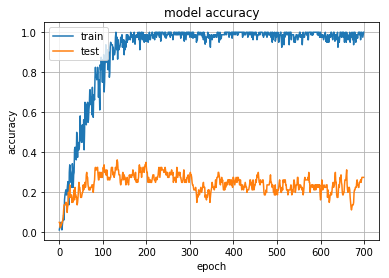

In [14]:
# Lets plot the results
print(history.history.keys())
# history accuracy
plt.plot(history.history["categorical_accuracy"])
plt.plot(history.history["val_categorical_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.grid()
plt.show()

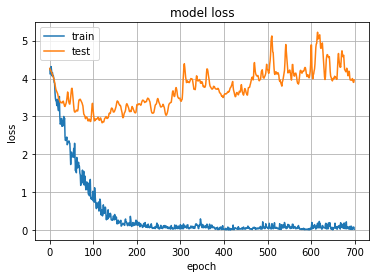

In [15]:
# history accuracy
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.grid()
plt.show()

In [16]:
# Lets predict
path = valDB + os.sep + "airport" + os.sep
imagesPredict = [f for f in listdir(path) if isfile(join(path,f))]

for file in imagesPredict:
    img = load_img(path + file, target_size=( 299, 299))
    tensorImage = img_to_array(img) /255.
    tensorImage = np.expand_dims(tensorImage, axis=0)
    prediction = model.predict(tensorImage, batch_size = 1)
    index = np.where(prediction[0] == max(prediction[0]))[0]
    if (0 != index[0].size):
        print("file "+ file + " is: " + classList[int(index[0])])

file airport_26_1_msrgb.jpg is: airport
file airport_55_0_msrgb.jpg is: impoverished_settlement
file airport_45_3_msrgb.jpg is: tunnel_opening
file airport_6_0_msrgb.jpg is: amusement_park


In [17]:
loadedModel = load_model("InceptionModel.h5")

path = trainDB + os.sep + "airport" + os.sep
imagesPredict = [f for f in listdir(path) if isfile(join(path,f))]
# print(imagesPredict)


for file in imagesPredict:
    img = load_img(path + file, target_size=( 299, 299))
    tensorImage = img_to_array(img) /255.
    tensorImage = np.expand_dims(tensorImage, axis=0)
    prediction = loadedModel.predict(tensorImage, batch_size = 1)
    index = np.where(prediction[0] == max(prediction[0]))[0]
    if (0 != index[0].size):
        print("file "+ file + " is: " + classList[int(index[0])])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
file airport_319_0_msrgb.jpg is: airport
file airport_118_5_msrgb.jpg is: airport
file airport_40_5_msrgb.jpg is: airport
file airport_139_1_msrgb.jpg is: airport
file airport_407_0_msrgb.jpg is: airport
file airport_166_8_msrgb.jpg is: airport
file airport_30_6_msrgb.jpg is: airport
file airport_118_7_msrgb.jpg is: airport
file airport_211_1_msrgb.jpg is: airport
file airport_7_8_msrgb.jpg is: airport
file airport_312_0_msrgb.jpg is: airport
file airport_299_2_msrgb.jpg is: airport
file airport_118_2_msrgb.jpg is: airport
file airport_431_0_msrgb.jpg is: airport
file airport_199_7_msrgb.jpg is: airport
